In [323]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

<b><h3>Unsupervisd Learning</h3></b>

The term $unsupervised\;learning$ refers to statistical methods that extract meaning from data without training a model on labeled data (data where an outcome of interest is known). In $supervised\;learning$, the goal is to build a model (set of rules) to predict a response variable from a set of predictor variables. In contrast, unsupervised learning also constructs a model of the data, but it does not distinguish between a response variable and predictor variables.

Unsupervised learning can be used to achieve different goals. In some cases, it can be used to create a predictive rule in the absence of a labeled response. $Clustering$ methods can be used to identify meaningful groups of data. For example, using the web clicks and demographic data of a user on a website, we may be able to group together different types of users. The website could then be personalized to these different types.

In other cases, the goal may be to $reduce\;the\;dimension$ of the data to a more manageable set of variables. This reduced set could then be used as input to a predictive model, such as regression or classification. For example, we may have thousands of sensors to monitor an industrial process. By reducing the data to a smaller set of features, we may be able to build a more powerful and interpretable model to predict process failure than could be built by including data streams from thousands of sensors.

Finally, unsupervised learning can be viewed as an extension of the exploratory data analysis to situations in which you are confronted with a large number of variables and records. The aim is to gain insight into a set of data and how the different variables relate to each other. Unsupervised techniques allow you to sift through and analyze these variables and discover relationships.

<b><h4>Unsupervised Learning and Prediction</h4></b>

Unsupervised learning can play an important role in prediction, both for regression and classification problems. In some cases, we want to predict a category in the abscence of any labeled data. For example, we might want to predict the type of vegetation in an area from a set of satellite sensory data. Since we don't have a response variable to train a model, clustering gives as a way to identify common patterns and categorize the regions.

Clustering is an especially important tool for the "cold-start problem". In this type of problem, such as launching a new marketing campaign or identifying potential new types of fraud or spam, we initially may not have any response to train a model. Over time, as data is collected, we can learn more about the system and build a traditional predictive model. But clustering helps us start the learning process more quickly by identifying population segments.

Unsupervised learning is also important as a building block for regression and classification techniques. With big data, if a small subpopulation is not well represented in the overall population, the trained model may not perform well for that subpopulation. With clustering, it is possible to identify and label subpopulations. Alternatively, the subpopulation can be represented with its own feature, forcing the overall model to explicitly consider subpopulation identity as a predictor.

<b><h3>Principal Component Analysis</h3></b>

Often, variables will vary together (covary), and some of the variation in one is actually duplicated by variation in another (eg restaurant checks and tips). Principal component analysis (PCA) is a technique to discover the way in which numeric variables covary.

The idea in PCA is to combine multiple numeric predictor variables into a smaller set of variables, which are $weighted$ $linear$ $combinations$ of the original set. The smaller set of variables, the principal components, "explains" most of the variability of the full set of variables, reducing the dimension of the data. <em>The weights used to form the principal components reveal the relative contributions of the original variables to the new principal components</em>.

The author of PCA recognized that in many problems there is variability in the predictor variables, so he developed PCA as a technique to model this variability. PCA can be viewed as the unsupervised version of linear discriminant analysis.

<b><h4>A Simple Example</h4></b>

For two variables, $X_1$ and $X_2$, there are two principal components $Z_i$ (i=1 or 2):

$Z_i=w_{i,1}X_1+w_{i,2}X_2$

The weights ($w_{i,1},w_{i,2}$) are known as the component $loadings$. These transform the original variables into the principal components. The first principal component, $Z_1$, is the linear combination that best explains the total variation. The second principal component, $Z_2$, is orthogonal to the first and explains as much of the remaining remaining variation as it can. (If there were additional components, each additional one would be orthogonal to the others). (It is also common to compute principal components on deviations from the means of the predictor variables, rather than on the values themselves). In Python, to compute principal components, we can use the scikit-learn implementation sklearn.decomposition.PCA.

In [324]:
sp500_px = pd.read_csv('../data/sp500_data.csv.gz', index_col=0)

In [325]:
oil_px = sp500_px[['XOM', 'CVX']]
pcs = PCA(n_components=2)
print(pcs.fit(oil_px))

PCA(n_components=2)


In [326]:
loadings = pcs.components_
loadings = pd.DataFrame(loadings, columns=oil_px.columns, index=['first', 'second'])
loadings

,XOM,CVX
first,-0.664711,-0.747101
second,0.747101,-0.664711


The weights for XOM and CVX for the first principal components are -0.747 and -0.665; forr the second principal components they are 0.665 and -0.747. How do we interpret this? The first principal component is essentially an average of CVX and XOM, reflecting the correlation between the two energy companies. The second principal component measures when the stock prices of CVX and XOM diverge. It is instructive to plot the principal components with the data.

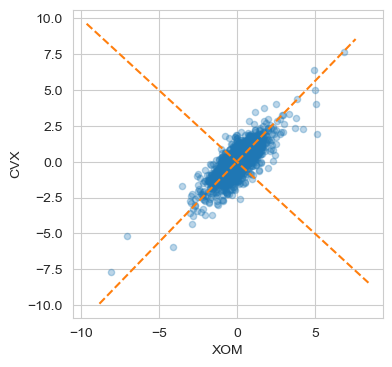

In [327]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)


ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4,4))
# ax.set_xlim(-3,3)
# ax.set_ylim(-3,3)
ax.plot(*abline(loadings.loc['first','CVX'] / loadings.loc['first', 'XOM'], 0, ax), '--', color='C1')
ax.plot(*abline(loadings.loc['first', 'CVX'] / loadings.loc['second', 'XOM'], 0, ax), '--', color='C1')


The dashed lines show the direction of the two principal components. Imagine an ellipse being drawn near the center of the data points. The first principal component lies along the long axis of the ellipse, and the second one is along the short axis. You can see that a majority of the variability is explained by the first principal component. This makes sense since energy stock prices tend to move as a group. The weights for the first principal component are both negative, but reversing the sign of all weights does not change the principal component. For example, using weights 0.747 and 0.655 for the first principal component is equivalent to the negative weights, just as an infinite line defined by the origin and 1,1 is the same as the one defined by the origin and -1,-1,

<b><h4>Computing the Principal Components</h4></b>

Going from two variables to more variables is straightforward. For the first component, simply include the additional predictor variables in the linear combination, assigning weights that optimize the collection of the covariance from all the predictor variables into this first principal component. Calculation of principal components is a classical statistical method, relying on either the correlation matrix of the data or the covariance matrix, and it executes rapidly, not relying on iteration. As noted earlier, principal components analysis only works with numeric variables, not categorical ones. The full process can be described as follows:

1. In creating the first principal component, PCA arrives at the linear combination of predictor variables that maximizes the percent of total variance explained.
2. This linear combination then becomes the first "new" predictor, $Z_1$.

3. PCA repeats this process, using the same variables with different weights, to create a second new predictor $Z_2$. The weighting is done in such a way that $Z_1$ and $Z_2$ are uncorrelated.

4. The process continues untilyou have as many new variables, or components, $Z_1$ as original variables $X_1$.

5. Choose to retain as many components as are needed to account for most of the variance.

6. The result so far is a set of weights for each component. The final step is to convert the original data into new principal component scores by applying the weights to the original values. The new scores can then be used as the reduced set of predictor variables.

In [328]:
oil_px.corr()

,XOM,CVX
XOM,1.000000,0.789698
CVX,0.789698,1.000000


In [329]:
first_component = loadings.loc['first', 'XOM']*oil_px['XOM'] + loadings.loc['first', 'CVX']*oil_px['CVX']
first_var = np.var(first_component)
first_var # first component variance captures the covariance between the two predictors.

0.7780870806700925

In [330]:
oil_px.XOM.var() + oil_px.CVX.var()

0.8686921969149217

In [331]:
second_component = loadings.loc['second', 'XOM']*oil_px['XOM'] + loadings.loc['second', 'CVX']*oil_px['CVX']
second_var = np.var(second_component)
second_var + first_var

0.8685383644026295

<b><h4>Interpreting Principal Components</h4></b>

The nature of the principal components reveals information about the structure of the data. There are a couple of standard visualization displays to help you glean insight about the principal components. One such method is a $screeplot$ to visualize the relative importance of principal components (the name derives from the resemblance of the plot to a scree slope; here the y-axis is the eigen value). The information to create a loading plot from the scikit-lean result is available in explained_variance_ and explained_variance_ratio_. 

Text(0.5, 0, 'Component')

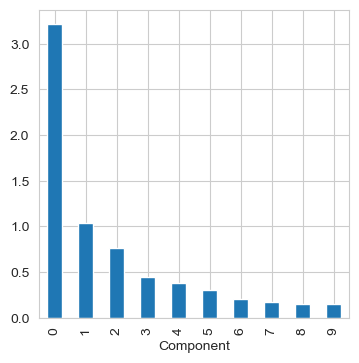

In [332]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])

top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA() # n_components=None, to keep all principal components
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')

Text(0.5, 0, 'Component')

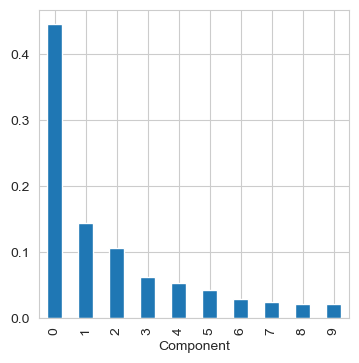

In [333]:
explained_variance_ratio = explained_variance = pd.DataFrame(sp_pca.explained_variance_ratio_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')

It can be especially revealing to plot the weights of the top principal components.

In [334]:
loadings = pd.DataFrame(sp_pca.components_[0:5,:], columns = top_sp.columns)
loadings.shape

(5, 16)

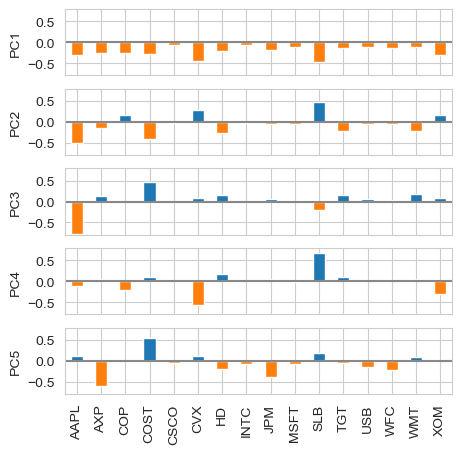

In [335]:
maxPC = 1.01 * np.max(np.max(np.abs(loadings.loc[0:5,:]))) # np.max() twice. First is max in default axis. 

f, axes = plt.subplots(5,1, figsize=(5,5), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i,:]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f"PC{i+1}")
    ax.set_ylim(-maxPC, maxPC)

The loadings for the top five components are shown above. The loadings for the first principal component have the same sign: this is typical for data in which all the columns share a common factor (in this case, the overall stock market trend). The second component captures the price changes of energy stocks as compared to the other stocks. The third component is primarily a contrast in the movements of Apple and CostCo. The fourth component contrasts the movements of Schlumberger (SLB) to the other energy stocks. Finally, the fifth component is mostly dominated by financial companies.

<b><h4>How Many Components to Choose?</h4></b>

If the goal is to reduce the dimension of the data, you must decide how many principal components to select. The most common approach is to use an ad hoc rule to select the components that explain "most" of the variance. You can do this visually through the screeplot. Alternatively, you could select the top components such that the cumulative variance exceeds a threshold, such as 80%. Also you inspect the loadings to determine if the component has an intuitive interpretation. Cross-validation provides a more formal method to select the number of significant components.

<b><h4>Correspondence Analysis</h4></b>

PCA cannot be used for categorial data; however, a somewhat related technique is $correspondence\;analysis$. The goal is to recognize associations between categories, or between categorical features. The similarities between categorical analysis and principal components analysis is mainly under the hod - the matrix algebra for dimension scaling. Correspondence analysis is used mainly for graphical analysis of low-dimensional categorical data and is not used in the same way that PCA is for dimension reduction as a preparatory step with big data.

The input can be seen as a table, with rows representing one varible and columns another, and the cells representing record counts. The output (after some matrix algebra) is a biplot- a scatterplot with axes scaled (and with percentages indicating how much variance is explained by that dimension). The meaning of the units on the axes is not intuitively connected to the original data, and the main value of the scatterplot is to illustrate graphically variables that are associated with one another (by proximity on the plot). In Python, we use the $prince$ package, which implements correspondence analysis using the scikit-learn API.

In [336]:
housetasks = pd.read_csv('../data/housetasks.csv', index_col=0) # label index makes it a contingency table
housetasks

,Wife,Alternating,Husband,Jointly
Task,,,,
Laundry,156,14,2,4
Main_meal,124,20,5,4
Dinner,77,11,7,13
Breakfast,82,36,15,7
Tidying,53,11,1,57
Dishes,32,24,4,53
Shopping,33,23,9,55
Official,12,46,23,15
Driving,10,51,75,3


In [337]:
ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

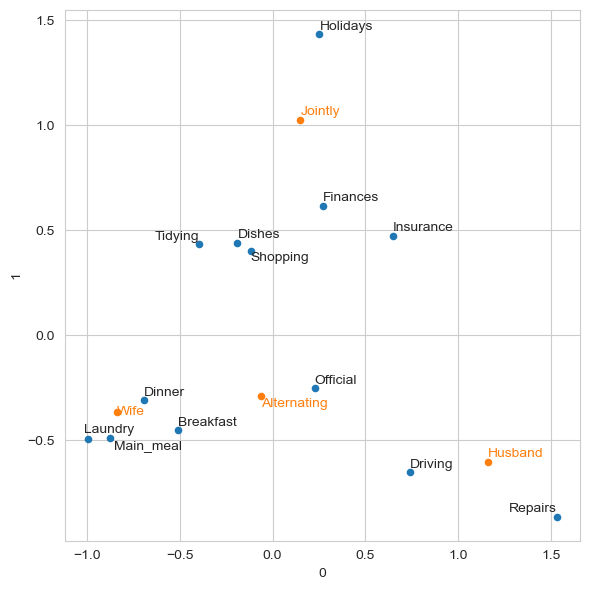

In [338]:
from adjustText import adjust_text

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6), ax=ax, c='C1')
texts=[]
for idx,row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, c='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()


<b><h4>Key Ideas</h4></b>

- Principal components are linear combination of the predictor variables (numeric data only).
- Principal components are calculated so as to minimize correlation between components, reducing redundancy.
- A limited number of components will typically explain most of the variance in the outcome variable.
- The limited set of principal components can then be used in place of the (more numerous) original predictors, reducing dimensionality.
- A superficially similar techique for categorical data is correspondence analysis but it is not useful in a big data context.

<b><h3>K-Means Clustering</h3></b>

Clustering is a technique to divide data into different groups, where the records in each group are similar to one another. A goal of clustering is to identify significant and meaningful groups of data. The groups can be used directly, analyzed in more depth, or passed as a feature or an outcome to a predictive regression or classification model. K-means was the first clustering method to be developed; it is still widely used, owing its popularity to the relative simplicity of the algorithm and its ability to scale to large data sets.

K-means divide the data into K clusters by minimizing the sum of the squared distances of each record to the mean of its assigned cluster. This is referred to as the within-cluster sum of squares of within-cluster SS. K-means does not ensure that the clusters will have the same size but finds the clusters that are best separated.

It is typical to normalize (standardize) continuous variales by subtracting the mean and dividing by the standard deviation. Otherwise, variables with large scale will dominate the clustering process.

<b><h4>A Simple Example</h4></b>

Start by considering a data set with $n$ records and just two variables, $x$ and $y$. Suppose we want to split the data into K = 4 clusters. This means assigniing each record $(x_i, y_i)$ to a cluster $k$. Given an assignment of n_k records to cluster k, the center of the cluster $(\bar x_k, \bar y_k)$ is the mean of the points in the cluster.

$\bar x_k = \dfrac{1}{n_k}\sum_{i\; \epsilon\; Cluster\;k}x_i$

$\bar y_k = \dfrac{1}{n_k}\sum_{i\; \epsilon\; Cluster\;k}y_i$

Th sum of squares within a cluster is given by:

$SS_k=\sum_{i\; \epsilon\; Cluster\;k}(\bar x_i - \bar x_k)^2 +(\bar y_i - \bar y_k)^2$

K-means finds the assignment of records that minimizes within-cluster sum of squares across all four clusters $SS_1+SS_2+SS_3+SS_4$:

$\sum_{k=1}^4SS_k$

A typical use of clustering is to locate natural, separate clusters in the data. Another application is to divide the data into a predetermined number of separate groups, where clustering is used to ensure the groups are as different as possible from one another. In Python, we use the sklearn.cluster.KMeans method from scikit-learn. After fitting to the data, the cluster labels are accessed via the labels_ keyword. The cluster centers are available in the clusters_centers_ field.

In [339]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)

In [340]:
df['cluster'] = kmeans.labels_
df.head()

,XOM,CVX,cluster
2011-01-03,0.736805,0.240681,0
2011-01-04,0.168668,-0.584516,3
2011-01-05,0.026631,0.446985,0
2011-01-06,0.248558,-0.919751,3
2011-01-07,0.337329,0.180511,0


In [341]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
centers

,XOM,CVX
0,0.231540,0.316965
1,-1.144397,-1.757796
2,0.927032,1.346412
3,-0.330814,-0.574398


In the example just above used KMeans on the stock data for exxon mobil and chevron stock returns, which are reported in a sort of standardized fashion so we dont need to normalize the data. Clusters 1 and 3 represent 'down markets', clusters 2 and 4 represent 'up markets'. As K-Means algorithm uses randomized starting points, the results may differ betwee subsequent runs and different implementations of the method. With just two variables, it is straightforward to visualize the clusters and their means.

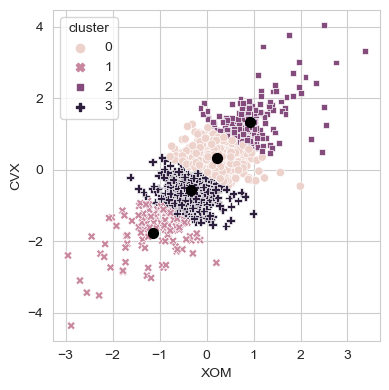

In [342]:
fig, ax = plt.subplots(figsize=(4,4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', ax=ax, data=df)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')
plt.tight_layout()


<b><h4>K-Means Algorithm</h4></b>

In general, K-means can be applied to a data set with p variables, $X_1,...,X_p$. While the exact soluion to K-means is computationally very difficult, heuristic algorithms provide an efficient way to compute a locally optimal solution. The algorithm starts with a user-specified K and an initial set of cluster means and then iterates the following steps:

1. Assign each record to the nearest cluster mean as measured by squared distance.
2. Compute the new cluster means based on the assignment of records.

The algorithm converges when the assignment of records to clusters does not change. For the first iteration, you need to specify an initial set of cluster means. Usually you do this by randomly assigning each record to one of the K clusters and then finding the means of those clusters. Since the algorithm isnt guarangeed to find the best possible solution, it is recommended to run the algorithm several times using different random samples to initialize the algorithm. When more than one set of iterations is used, the K-means result is given by the iteration that has the lowest within cluster sum of squares. The scikit-learn algorithm is repeated 10 times by default. The argument max_iter(default 300) can be used to control the number of iterations.

In [343]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)


<b><h4>Interpreting the Clusters</h4></b>

An important part of cluster analysis can involve the interpretation of the clusters. The two most important outputs from kmeans are the sizes of the clusters and the cluster means. The sizes of the clusters can be obtained with a Counter() object. A plot of the (coordinates of the) centers of the clusters can shed more light into the nature of the clusters.

Here, the cluster sizes are relatively balanced. Imbalanced clusters can result from distant outliers, or from groups of records very distinct from the rest of the data - both may warrant further inspection.

In [344]:
from collections import Counter

count = Counter(kmeans.labels_)
pd.Series(dict(count), name= 'clusters')

4    290
2    251
3    298
0    185
1    107
Name: clusters, dtype: int64

In [345]:
pd.DataFrame(centers)

,XOM,CVX
0,0.231540,0.316965
1,-1.144397,-1.757796
2,0.927032,1.346412
3,-0.330814,-0.574398


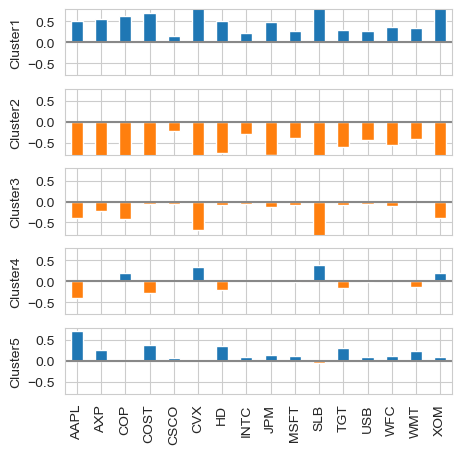

In [346]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5,1, figsize=(5,5),sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i,:]
    maxPc = 1.01*np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f"Cluster{i+1}")
    ax.set_ylim(-maxPC, maxPC)

Remember that each record represents a day of stocks. The resulting plot reveals the nature of each cluster. For example, clusters 3 and 4 correspond to days on which the market is down; clusters 2 and 5 correspond to days on which the market is up. Cluster 1 corresponds to days in which energy stocks were up and consumer stocks were down.

The plot of cluster means is similar in spirit to looking at the loadings for principal components analysis (PCA). A major distinction is that unlike with PCA, the sign of the cluster means is meaningful. PCA identifies principal directions of variation, whereas cluster analysis finds groups of records located near one another.

<b><h4>Selecting the Number of Clusters</h4></b>

The K-means algorithm requires that you specify the number of clusters K. Sometimes the number of clusters is driven by the application. For example, a company managing a sales forece might want to cluster customers into "personas" to focus and guide sales calls. In such a case, managerial considerations would dictate the number of desired customer segments - for example, two might yield useful differentiations of customers, while eight might be too many to manage. In the absence of a cluster number dictated by practical or managerial considerations, a statistical approach could be used. The is no single standard method to find the "best" number of clusters.

A common approach, called the $elbow\;method$, is to identify when the set of clusters explains "most" of the variance in the data. Adding new clusters beyond this set contributes relatively little in the variance explained. The elbow is the point where cumulative variance explained flattens out after rising steeply, hence the name of the method. For the KMeans result in Python, we get this information from the $inertia\_$ property (within-cluster SSE). After conversion to a pandas data frame, we can use its plot() method to create the graph.

In evaluating how many clusters to retain, perhaps the most important test is this: how likely are the clusters to be replicated on new data? Are the clusters interpretable, and do they relate to a general characteristic of the data, or do they just reflect a specific instance? You can access this, in part, using cross-validation.

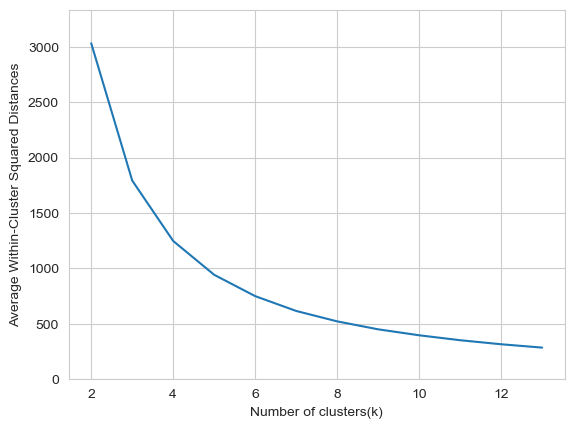

In [347]:
inertia = []
for n_clusters in range(2,14):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2,14), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

<b><h3>Hierarchical Clustering</h3></b>

$Hierarchical\;clustering$ is an alternative K-means that can yield very different clusters. Hierarchical clustering allows the user to <em>visualize the effect of specifying different number of clusters</em>. It is more <em>sensitive in discovering outlying or aberrant groups or records</em>.Hierarchical clustering also lends itself to an <em>intuitive graphical display</em>, leading to easier interpretation of the clusters. Hierarchical clustering's flexibility comes with a cost, and hierarchical clustering does not scale well to large data sets with millions of records. For even modest-sized data with just tens of thousands of records, hierarchical clustering can require intensive computing resources. Indeeed, most of the applications of hierarchical clustering are focused on relatively small data sets.

<b><h4>A Simple Example</h4></b>

Hierarchical clustering works on a data set with $n$ records and $p$ variables and is based on two basic building blocks:

- A distance metric $d_{i,j}$ to measure the distance between two records $i$ and $j$.
- A dissimilarity metric $D_{A,B}$ to measure the difference between two clusters A and B based on the distances $d_{i,j}$ between the members of each cluster.

For applications involving numeric data, the most important choice is the dissimilarity metric. Hierarchical clustering starts by setting each record as its own cluster and iterates to <em>combine the least dissimilar clusters</em>. The scipy package offers a number of different methods for hierarchical clustering in the <em>scipy.cluster.hierarchy</em> module. Here we use the <em>linkage</em> function with the "complete" method.

In [348]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']

df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')

<b><h4>The Dendogram</h4></b>

Hierarchical clustering lends itself to a natural graphical display as a tree, referred to as a <em>dendogram</em>. In Python we can use the <em>dendrogram</em> function from <em>scipy.cluster.hierarchy</em> to plot the result of the <em>linkage</em> function.

Text(0, 0.5, 'distance')

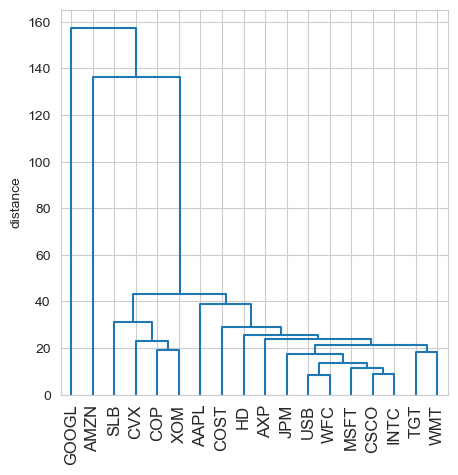

In [349]:
fig, ax = plt.subplots(figsize=(5,5))
dendrogram(Z, labels=df.index, ax=ax, color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

In the dendrogram above, we are now plotting companies that are similar to one another, not days. The leaves of the tree corresponds to the records. The length of the branch in the tree indicates the degree of dissimilarity between corresponding clusters. The returns from Google and Amazon are quite dissimilar to one another and to the returns for the other stocks. The oil stocks (SLB, CVX, XOM, COP) are in their own cluster, Apple (AAPL) is by itself, and the rest are similar to one another.

In contrast to K-means, it is not necessary to prespecify the number of clusters. Graphically, you can identify different number of clusters with a horizontal line that slides up or down; a cluster is defined wherever the horizontal line intersects the vertical lines. To specify the number of clusters, you can use the <em>fcluster</em> function from <em>scipy.cluster.hierarchy</em> instead <em>dendrogram</em>, and providing the output of the <em>linkage</em> function. This function will produce an output similar to knn where each item has a group id. Comparing the group ids to the dendrogram explains the horizontal line rule for identifying clusters.

In [350]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key}: {','.join(item.index)}")


1: COP,CVX,SLB,XOM
2: AAPL,AXP,COST,CSCO,HD,INTC,JPM,MSFT,TGT,USB,WFC,WMT
3: AMZN
4: GOOGL


With the number of clusters to extract set to 4, you can see that Google and Amazon each belong to their own cluster. The oil stocks all belong to another cluster. The remaining stocks are in the fourth cluster.

<b><h4>The Agglomerative Algorithm</h4></b>

The main algorithm for hierarchical clustering is the <em>agglomerative</em> algorithm, which iteratively merge similar clusters. The agglomerative algorithm begins with each record constitutiong its own single-record cluster and then builds up larger and larger clusters. The first step is to calculate distances between all pairs of records.

For each pair of records $(x_1,x_2,...,x_p)$ and $(y_1,y_2,...,y_p)$, we measure the distance between the records, $d_{x,y}$ using a distance metric. For example, we can use Euclidean distance:

$d(x,y)=\sqrt {(x_1-y_1)^2 + (x_2+y_2)^2 + ... + (x_p - y_p)^2}$

We can now turn to inter-cluster distance. Consider two clusters $A$ and $B$, each with a distinctive set of records, $A=(a_1,a_2,...,a_m)$ and $B=(b_1,b_2,...,b_q)$. We can measure the dissimilarity between the clusters $D(A,B)$ by using the distances between the members of $A$ and the members of $B$. One such measure of dissimilarity is the <em>complete-linkage</em> method, which is the maximum distance across all pairs of records between $A$ and $B$:

$D(A,B) = max(d(a_i,b_j))$ for all pairs i,j

This defines the dissimilarity as the biggest difference between all pairs.

The main steps of the agglomerative algorithm are:
1. Create an initial set of clusters with each cluster consisting of a single record for all records in the data.
2. Compute the dissimilarity $D(C_k,C_l)$ between all pairs of clusters $k,l$.
3. Merge the two clusters $C_k$ and $C_l$ that are least dissimilar as measured by $D(C_k,C_k)$.
4. If we have more than one cluster remaining, return to step 2. Otherwise, we are done.

<b><h4>Measures of Dissimilarity</h4></b>

These are four common measures of dissimilarity: <em> complete linkage, single linkage, average linkage</em>, and <em>miminum variance</em>. The complete linkage method tends to produce clusters with members that are similar. 

The single linkage method is the minimum distance between the records in two clusters:

$D(A,B) = min(d(a_i,b_j))$ for all pairs i,j

This is a "greedy" method and produces clusters that con contain quite disparate elements. 

The average likage method is the average of all distance pairs and represents a compromise between the single, and complete linkage methods. Finally, the minimum variance method, also referred to as <em>Ward's</em> method, is similar to K-means since it minimizes the within-cluster sum of squares.

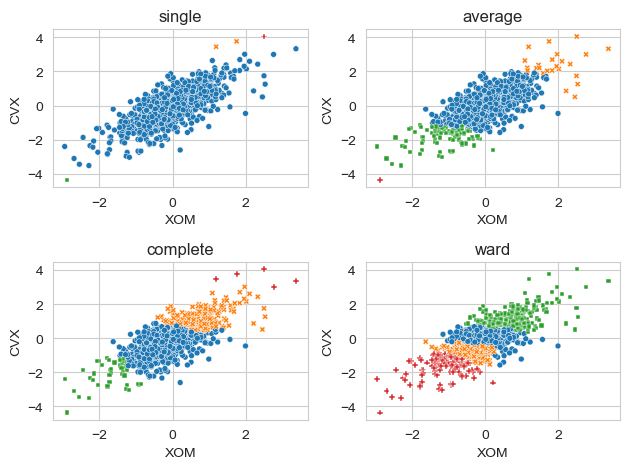

In [351]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2)
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i//2, i%2] # i is 0-indexed
    Z  = linkage(df, method=method)
    colors  = [f"C{c+1}" for c in fcluster(Z,4, criterion='maxclust')] # encode clusters
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,size=0.5,ax=ax,data=df,legend=False)
    # ax.set_xlim(-3,3)
    # ax.set_ylim(-3,3)
    ax.set_title(method)

plt.tight_layout()


The results are strikingly different: the single linkage measure assigns almost all of the points to a single cluster. Except for the minimum variance method (ward), all measures end up with at least one cluster with just a few outlying points. The minimum variance method is most similar to the K-means cluster (compare to the K-Means diagram above).

Note the agglomeration history after is retained and plotted, and the user (without specifying the number of clusters beforehand) can visualize the number and structure of clusters at different stages aka dendrogram.

<b><h3>Model-Based Clustering</h3></b>

Clustering methods such as hierarchical clustering and K-means are based on heuristics and rely primarily on finding clusters whose members are close to one another, as measured directly with the data (no probability model involved). Model-based clustering techniques are based in statistical theory and provide more rigorous ways to determine the nature and number of clusters. They could be used, for example, in cases where there might be one group of records that are similar to one another but not necessarily close to one another (eg tech stocks with high variance of returns) and another group of records that are similar and also close (dg utility stocks with low variance).

<b><h4>Multivariate Normal Distribution</h4></b>

The most widely used model-based clustering methods rest on the multivariate normal distribution. The multivariate normal distribution is a generalization of the normal distribution to a set of p variables $X_1, X_2, ..., X_p$. The distribution is defined by a set of means $\mu = \mu_1, \mu_2, ..., \mu_p$ and a covariance matrix $\Sigma$. The covariance matrix is a measure of how the variables correlate with each other. The covariance matrix $\Sigma$ consists of $p$ variances $\sigma_1^2, sigma_2^2, ... , sigma_p^2$ and covariances $sigma_{i,j} for all pairs of variables $i\neq j$. With the variables put along the rows and duplicated along the columns, the matrix looks like this:


$\Sigma=\begin{bmatrix} \sigma_1^2 & \sigma_{1,2} & ... & \sigma_{1,p} \\ \sigma_{2,1} & \sigma_2^2 & ... & \sigma_{2,p} \\ : & : & : & : \\ \sigma_{p,1} & \sigma_{p,2} & ... & \sigma_p^2 \end{bmatrix}$.

Note that the covariance matrix is symmetric around the diagonal from upper left to lower right. Since $\sigma_{i,j}=\sigma_{j,i}$, there are only $(p$ x $(p-1))/2$ covariance terms. In total, the covariance matrix has $(p$ x $(p-1))/2+p$ parameters. The distribution is denoted by:

$(X_1, X_2, ..., X_p)$ ~ $N_p(\mu,\Sigma)$

This is a symbolic way of saying that the variables are normally distributed, and the overall distribution is fully described by the vector of variable means and the covariance matrix. 

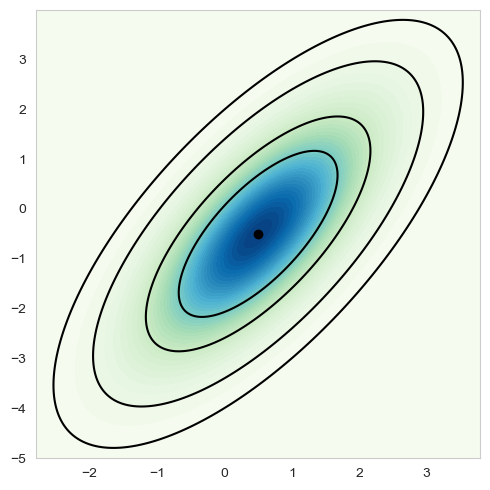

In [352]:
mean = [0.5, -0.5]
cov = [[1,1], [1,2]]
probability = [0.5, 0.75, 0.95, 0.99]
def probLevel(p):
    D = 1
    return (1-p)/(2*math.pi*D)
levels = [probLevel(p) for p in probability]

fig, ax = plt.subplots(figsize=(5,5))

x, y = np.mgrid[-2.8:3.8:.01, -5:4:.01]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
rv = multivariate_normal(mean, cov)

CS = ax.contourf(x, y, rv.pdf(pos), cmap=cm.GnBu, levels=50)
ax.contour(CS, levels=levels, colors=['black'])
ax.plot(*mean, color='black', marker='o')

plt.tight_layout()


<b><h4>Mixtures of Normals</h4></b>

The key idea behind model-based clustering is that each record is assumed to be distributed as one of K multivariate normal distributions, where K is the number of clusters. Each distribution has a different mean $\mu$ and covariance matrix $\Sigma$. For example, if you have two variables $X$ and $Y$, then each row $(X_i,Y_i)$ is modeled as having been sampled from one of K multivariate normal distributions $N(\mu_1,\Sigma_1),N(\mu_2,\Sigma_2),..., N(\mu_K,\Sigma_K)$. scikit-learn has the sklearn.mixture.GaussianMixture class for model-based clustering.

In [353]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
mclust.bic(df)  # Bayesian information criterion for the current model on the input X.

4590.064133153179

<Axes: xlabel='XOM', ylabel='CVX'>

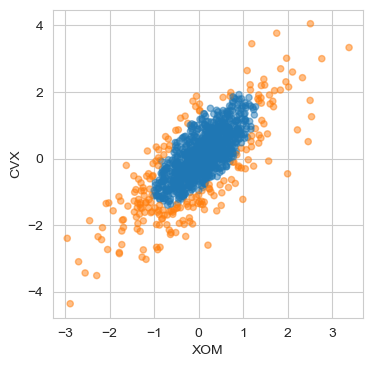

In [354]:
fig, ax = plt.subplots(figsize=(4,4))
colors = [f"C{c}" for c in mclust.predict(df)]
df.plot.scatter(x='XOM',y='CVX', c=colors, alpha=0.5, ax=ax)


There are two clusters: one cluster in the middle of the data, and a second cluster in the outer edge of the data. This is very different from the clusters obtained using K-means and hierarchical clustering, which find clusters that are compact. You can extract the parameters to the normal distributions from the <em>means_</em> and <em>covariances_</em>. The distributions have similar means and correlations, but the second distribution has much larger variances and covariances. 

The clusters in the example may seem surprising, but in fact, they illustrate the statistical nature of the method. The goal of model-based clustering is to find the best-fitting set of multivariate normal distributions. The stock data appears to have a normal-looking shape, but in fact stock returns have a longer-tailed distribution than a normal distribution. To handle this, the model fits a distribution to the bulk of the data but then fits a second distribution with a bigger variance.

In [355]:
print("Mean\n")
print(mclust.means_, '\n')
print("Covariances\n")
print(mclust.covariances_)

Mean

[[ 0.07283435  0.10555253]
 [-0.05027639 -0.21089398]] 

Covariances

[[[0.26770716 0.27513521]
  [0.27513521 0.51587914]]

 [[0.96798717 0.97429323]
  [0.97429323 1.66712807]]]


<b><h4>Selecting the Number of Clusters</h4></b>

Unlike K-means and hierarchical clustering, multivariate normal models use the number of clusters for which the <em>Bayesian Information Criteria</em> has the largest value (BIC is similar to AIC). BIC works by selecting the best-fitting model with a penalty for the number of parameters in the model. In the case of model-based clustering, adding more clusters will always imporve the fit at the expense of introducing additional parameters in the model. There are different models with increasing number of components and GaussianMixture automatically chooses an optimal model. We can plot the BIC values of these models. In Python, it is straightforward to run multiple combinations of the number of clusters - or the number of different multivariate normal models. With the warm_start argument, the calculation will reuse information from the previous fit. This will speed up the convergence of subsequent calculations.

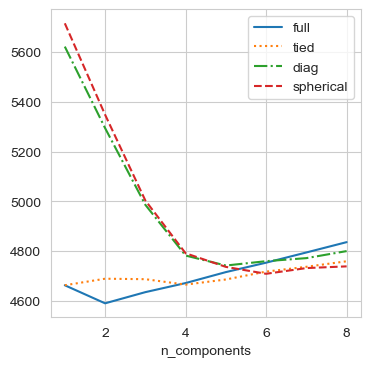

In [356]:
results=[]
covariance_types=['full', 'tied', 'diag', 'spherical']
for n_components in range(1,9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components=n_components, warm_start=True, covariance_type=covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
results = pd.DataFrame(results)
colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-', 'C1:', 'C0-.', 'C1--']
fig, ax = plt.subplots(figsize=(4,4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, kind='line', style=styles[i], color=colors[i])

The plot is similar to the elbow plot used to identify the number of clusters to choose for K-means, except the value being plotted is BIC instead of percent of variance explained. One big difference is that instead of one line, there are 4 different lines. This is because 4 different models are being fitted for each cluster size, and ultimately it chooses the best-fitting model. Why so many models to determine the best set of multivariate normals? It's because there are different ways to parameterize the covariance matrix $\Sigma$ for fitting a model. For the most part, data scientists do not need to worry about the details of the models and can simply use the model chosen by GaussianMixture.

Model-based clustering techniques do have some limitations. The methods require an underlying assumption of a model for the data, and the cluster results are very dependent on that assumption. The computations requirements are higher than even hierarchical clustering, making it difficult to scale to large data. Finally, the algorithm is more sophisticated and less accessible than that of other methods.

<b><h3>Scaling and Categorical Values</h3></b>

Unsupervised learning techniques generally require that the data be appropriately scaled. For example, with the personal loan data, the variables have widely different units and magnitude. Some variables have relatively small values (e.g., number of years employed), while others have very large values (e.g., loan amount in dollars). If the data is not scaled, the PCA, K-means and other clustering methods will be dominated by the variables with large values and ignore the variables with small values.

Categorical data can pose a special problem for some clustering procedures. As with K-Nearest Neighbors, unordered factor variables are generally converted to a set of binary (0/1) variables using one hot encoding. Not only are the binary variables likely on a different scale than other data, but the fact that binary variables have only two values can prove problematic with techniques such as PCA and K-Means.

<b><h4>Scaling the Variables</h4></b>

Variables with very different scale and units need to be normalized appropriately before you apply a clustering procedure.

In [365]:
loan_data = pd.read_csv('../data/loan_data.csv.gz')
defaults = loan_data.loc[loan_data['outcome'] == 'default',]
columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,10274.160906,41241.205530,9950.095008,9.480338,17.718588,57.903425,13023
1,21444.318867,148736.057263,33152.689572,12.376733,13.831145,63.151084,1654
2,24290.909091,409746.465909,84710.988636,13.431818,8.148636,60.015647,88
3,17809.760881,78669.452556,18933.405997,11.594003,17.016428,62.183810,7906


Above we have an application of the kmeans algorithm to the data of loan defaults without normalizing. The varaibles annual_inc and revol_bal dominate the clusters, and the clusters have very different sizes. Cluster 2 (0-indexed) has only 88 members with comparatively high income and revolviing credit balance.

A common approach to scaling the variables is to convert them to z-scores by subtracting the mean and dividing by the standard deviation. This is termed standardization or normalization.

$z=\dfrac{x-\bar x}{s}$

In Python, we can use scikit-learn's StandardScaler. The inverse_transform method allows converting the cluster centers back to the original scale.

In [368]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df*1.0)

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=columns)  # convert to original scale
centers['size'] = [counts[i] for i in range(4)]
centers

,loan_amnt,annual_inc,revol_bal,open_acc,dti,revol_util,size
0,10506.814810,51114.024278,11634.707310,7.509576,15.933778,77.784329,7399
1,10323.453512,53466.038196,6052.642631,8.664617,11.309106,30.990055,5357
2,25950.205142,116834.142232,32945.972921,12.396335,16.165914,66.123542,3671
3,13486.397177,55905.907924,16435.679660,14.322746,24.210014,59.462324,6244


The cluster sizes are more balanced, and the clusters are not dominated by annual_inc and revol_bal, revealing more interesting structure in the data. Note that the centers are rescaled to the original units in the preceding code. If we had left them unscaled the resulting values would be in terms of z-scores and would therefore be less interpretable.

Scaling is also important for PCA. Using z-scores is equivalent to using the correlation matrix instead of the covariance matrix in computing the principal components.

<b><h4>Dominant Variables</h4></b>

Even in cases where the variables are measured on the same scale and accurately reflect relative importance (e.g., movement to stock prices), it can sometimes be useful to rescale the variables.

Text(0.5, 0, 'Component')

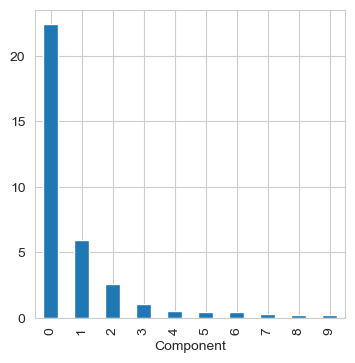

In [370]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4,4))
ax.set_xlabel('Component')

The screeplot displays the variances for the top principal components. In this case, the screeplot reveals that the variances of the first and second components are much larger than the others. This often indicates that one or two variables dominate the loadings.

In [376]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
loadings.transpose()

,0,1
GOOGL,-0.857310,0.477873
AMZN,-0.444728,-0.874149
AAPL,-0.071627,-0.020802
MSFT,-0.036002,-0.006204
CSCO,-0.029205,-0.003045
INTC,-0.026666,-0.006069
CVX,-0.089548,-0.037420
XOM,-0.080336,-0.020511
SLB,-0.110218,-0.030356
COP,-0.057739,-0.024117


<b><h4>Categorical Data and Gower's Distance</h4></b>

In the case of categorical data, you must convert it to numeric data, either by ranking (for an ordered factor) or by encoding as a set of binary (dummy) variables. If the data consists of mixed continuous and binary variables, you will usually want to scale the variables so that the ranges are similar. One popular method is to use Gower's distance. 

The basic idea behind Gower's distance is to apply a different distance metric to each variable depending on the type of data:
- For numeric variables and ordered factors, distance is calculated as the absolute value of the difference between two records.
- For categorical variables, the distance is 1 if the categories between two records are different, and the distance is 0 if the categories are the same.

Gower's distance is computed as follows:
1. Compute the distance $d_{i,j}$ for all pairs of variables $i$ and $j$ for each record.
2. Scale each pair $d_{i,j}$ so the minimum is 0 and the maximum is 1.
3. Add the pairwise scaled distances between variables together, using either a simple or a weighted mean, to create the distance matrix.

Once Gower's distance is calculated it can then be used for hierarchical clustering. Gower's distance is currently not implemented for Python.

<b><h4>Problems with Clustering Mixed Data</h4></b>

K-means and PCA are most appropriate for continuous variables. For smaller data sets, it is better to use hierarchical clustering with Gower's distance. In principle, there is no reason why K-means can't be applied to a binary or categorical data. You would usually use the one hot encoder representation to convert the categorical data to numeric values. In practice, however, using K-means and PCA with binary data can be difficult. 

If the standard z-scores are used, the binary variables will dominate the definition of the clusters. This is because 0/1 variables take on only two values, and K-means can obtain a small within-cluster sum of squares by assigning all records with a 0 or 1 to a single cluster. 

In [377]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df*1.0)
kmeans = KMeans(n_clusters=4, random_state=1).fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df.columns)
centers

,dti,payment_inc_ratio,pub_rec_zero,home__MORTGAGE,home__OWN,home__RENT
0,16.992128,9.105395,1.000000e+00,1.176836e-14,-1.346145e-15,1.000000e+00
1,17.456244,8.422914,1.000000e+00,1.000000e+00,-1.207368e-15,-2.275957e-15
2,16.504955,8.064247,1.110223e-16,5.156600e-01,9.714451e-17,4.843400e-01
3,17.197993,9.266666,9.179025e-01,-6.106227e-16,1.000000e+00,1.998401e-15


The top four clusters are essentially proxies for the different levels of the factor variables. To avoid this behavior, you could scale the binary variables to have a smaller variance than other variables. Alternatively, for very large data sets, you could apply clustering to different subsets of data taking on specific categorical values. For example, you could apply clustering separately to those loans made to someone who has a mortgage, owns a home outright, or rents.